<a href="https://colab.research.google.com/github/Frenchyy1/test/blob/master/NLP_CDA_with_FastAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Essai verbatims avec fast ai 

1. Importez les librairies nécessaires à la gestion de texte dans FastAi.

In [0]:
from fastai.text import *
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df = pickle.load( open( "/content/drive/My Drive/verbats1.pkl", "rb" ) )

In [0]:
df.head()

Commentaire positif/négatif  ...                                        Sous-thèmes
0  Commentaire positif et négatif  ...  Un séjour agréable/sympathique/chaleureux, Le ...
1             Commentaire positif  ...  Qualité des pistes / domaine skiable, Un séjou...
2             Commentaire positif  ...                     Séjour apprécié sans précision
3             Commentaire positif  ...                     Séjour apprécié sans précision
4             Commentaire positif  ...          Un séjour agréable/sympathique/chaleureux

[5 rows x 7 columns]

In [0]:
pd.set_option('display.max_colwidth', 400)

In [0]:
df1 = df[["Commentaire positif/négatif", "Commentaire"]]
df1.head()

Commentaire positif/négatif                                                                                          Commentaire
0  Commentaire positif et négatif     Séjour toujours très agréable même si les forfaits de ski deviennent de plus en plus chers......
1             Commentaire positif                                           STATION SPORTIVE-BEAU DOMAINE SKIABLE-AMBIANCE CHALEUREUSE
2             Commentaire positif                                                                                  Toujours un plaisir
3             Commentaire positif  cela fait + de 40 ans que je viens à Tignes, pour moi c'est le meilleur ski de France, jamais déçu.
4             Commentaire positif                                                                                     Séjour agréable

In [0]:
df1["Commentaire positif/négatif"].value_counts()

Commentaire positif               24982
Commentaire positif et négatif    19223
Name: Commentaire positif/négatif, dtype: int64

In [0]:
df1.isnull().sum()/len(df1) 

note           0.0
Commentaire    0.0
dtype: float64

In [0]:
df1['note']=df1['Commentaire positif/négatif'].apply(lambda x: 1 if x =='Commentaire positif' else 2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
df1 = df1[["note", "Commentaire"]]

In [0]:
df1=df1.dropna()

In [0]:
mask = np.random.rand(len(df1)) < 0.8

In [0]:
df1_train = df1[mask]
df1_test = df1[~mask]

In [0]:
df1.head()

note                                                                                          Commentaire
0     2     Séjour toujours très agréable même si les forfaits de ski deviennent de plus en plus chers......
1     1                                           STATION SPORTIVE-BEAU DOMAINE SKIABLE-AMBIANCE CHALEUREUSE
2     1                                                                                  Toujours un plaisir
3     1  cela fait + de 40 ans que je viens à Tignes, pour moi c'est le meilleur ski de France, jamais déçu.
4     1                                                                                     Séjour agréable

6. Créez maintenant un DataBunch adapté. Faites attention cependant, vous devrez utiliser un Tokenizer différent de celui par défaut. 

[Regardez la documentation en détail ](https://docs.fast.ai/text.transform.html#Tokenizer)

In [0]:
Path?

In [0]:
data_lm = TextLMDataBunch.from_df(Path(),
                                  train_df = df1_train,
                                  valid_df = df1_test,
                                  text_cols = 'Commentaire', 
                                  label_cols= "note",
                                  tokenizer= Tokenizer(lang="fr")
                                  )

7. Regarder un batch de données préprocessées

In [0]:
data_lm.show_batch()

# Text classifier

10. On va essayer de faire une prédiction maintenant de la note qu'une personne a laissée en fonction de la reviews qu'elle a écrite. Créez donc un nouveau DataBunch adapté à cette problématique 

In [0]:
data_clas = TextClasDataBunch.from_df(Path("model"), 
                                      train_df = df1_train,
                                      valid_df = df1_test,
                                      text_cols = 'Commentaire', 
                                      label_cols= "note",
                                      tokenizer= Tokenizer(lang="fr"),
                                      vocab = data_lm.train_ds.vocab
                                      )

11. Créez un modèle adapté 

In [0]:
classifier = text_classifier_learner(data_clas, AWD_LSTM)

12. Entrainez votre modèle sur 3 epochs 

In [0]:
classifier.fit_one_cycle(10)

13. On va tenter de faire mieux. Entrainez votre modèle en effectuant du fine-tuning sur le learning rate 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-09
Min loss divided by 10: 6.31E-10


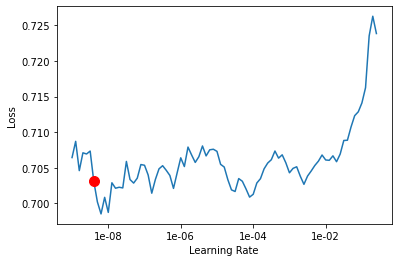

In [0]:
classifier.lr_find(start_lr=1E-10, end_lr=1)
classifier.recorder.plot(suggestion = True)

In [0]:
classifier.unfreeze()

In [0]:
classifier.fit_one_cycle(4, 5.01E-07)

In [0]:
classifier.fit_one_cycle(3)

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken p

KeyboardInterrupt: ignored

14. Puisque nous sommes sur de la classification, tentons de voir ce que nous propose l'interpréteur : ```ClassificationInterpretation```

In [0]:
interp = ClassificationInterpretation.from_learner(classifier)

15. Regardez la matrice de confusion pour voir où votre modèle s'est trompé 

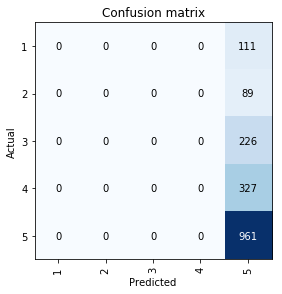

In [0]:
interp.plot_confusion_matrix()

16. Nous allons voir un autre interpréteur. Testez : ```TextClassificationInterpretation```

In [0]:
interp_text = TextClassificationInterpretation.from_learner(classifier)

17. Utilisez la méthode ```show_top_losses``` pour voir quelles sont les prédictions où le modèle s'est le plus trompé 

In [0]:
interp_text.show_top_losses(k=3)

18. Nous allons utiliser une autre méthode qui est : ```show_intrinsic_attention```. Insérez en input la première review de votre dataset et regardez le résultat. 

Que pouvez-vous dire ?

In [0]:
interp_text.show_intrinsic_attention(french_reviews.iloc[0,0])

#### L'output nous montre l'intention de chacun des tokens. Allant de vert = Très positif à rouge = Très négatif 

/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.


In [0]:
interp_text.show_intrinsic_attention("xxbos pas assez de petites activités pour faire patienter les enfants et étaler le monde dans le parc tout est hors de prix ca ne vaut pas europapark en allemagne ca ç est sur par contre les spectacles supers")

/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.


19. Tentez avec quelques autres reviews pour voir ce que propose votre modèle 

In [0]:
random_reviews = np.random.randn(len(french_reviews))<0.99

interp_text.show_intrinsic_attention(french_reviews[~random_reviews]["review_format"])

/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
